In [30]:
%matplotlib widget

In [31]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold
import scipy.special as sp

# setup plotting 
from IPython import get_ipython
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

# Load the data

In [32]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [33]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [34]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

5


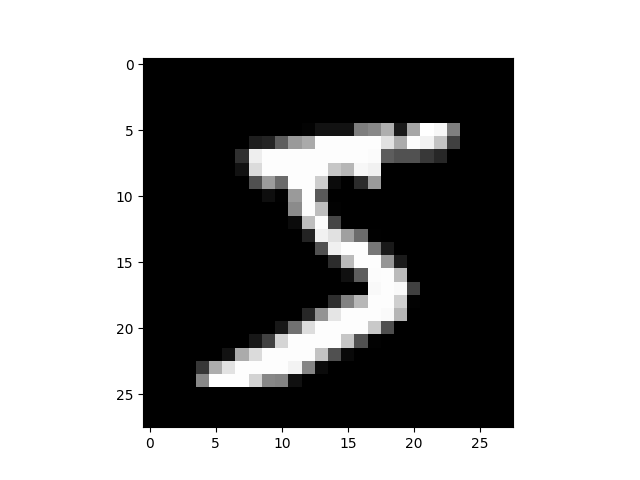

In [35]:
# Example: show first digit
nextplot()
showdigit(X[0,])
print(y[0])

In [36]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

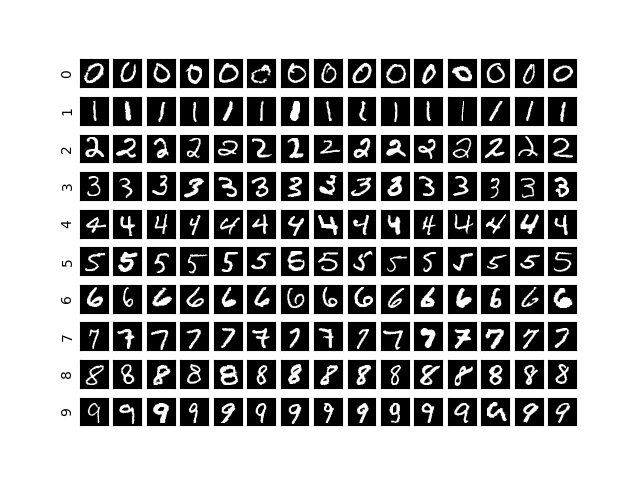

In [37]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

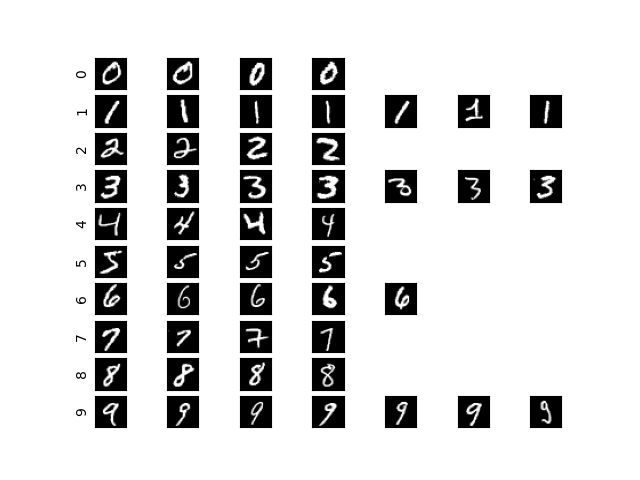

In [38]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [39]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

In [40]:
print(Xex, yex)

[[1 0]
 [0 1]
 [1 1]
 [2 0]] [0 1 2 0]


# 1 Training

In [41]:
from scipy.stats import dirichlet

def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = int(np.max(X)) + 1
    if C is None:
        C = int(np.max(y)) + 1


    # Compute class priors and store them in priors
    priors = np.zeros(C)
    # for each class, divide class count by total count, addind in pseudocounts according to alpha value 
    for c in range(C):
        # print(c)
        # print(np.sum(y == c))
        # print(np.sum(y == c) + alpha - 1), (N + (alpha - 1))
        priors[c] = (np.sum(y == c) + alpha - 1) / (N + (alpha - 1)*C)

    

    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K))
    # for each class, select all instances with corresponding class label
    for c in range(C):
        Xc = X[y == c]  
        # for each feature, get counts of its values in corresponding class
        for j in range(D):
            feature_counts = np.bincount(Xc[:, j], minlength=K)
            # divide feature count by total count, adding pseudocounts according to alpha value, and store in cls
            cls[c, j, :] = (feature_counts + alpha-1) / (len(Xc) + K * (alpha-1))


    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [42]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [43]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [44]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

In [45]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))

    # for each data point we first consider the log-prior probability of it belonging to each of the classes
    for i in range(Nnew):
        for c in range(C):
            logjoint[i,c] = logpriors[c]
            # and then increasy it by class-conditional log-likelihoods for each feature's value
            for j in range(D):
                x_j = Xnew[i, j]  # The value of feature j for instance i
                logjoint[i,c] += logcls[c, j, x_j]

    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")

    # predicted label corresponds to one with the highest log joint probability for each test point
    yhat = np.argmax(logjoint, axis=1)  
    # normalized logprob (normalization is not mandatory to choose label yhat itself, but helps to interpret how sure the classifier is about label assignment)
    logprob = np.max(logjoint, axis=1)-logsumexp(logjoint.T).T

    return dict(yhat=yhat, logprob=logprob)

In [46]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

# 3 Experiments on MNIST Digits Data

In [47]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [48]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

In [49]:
def baseline_classifier(X):
    """
    A baseline classifier that predicts a random class from 0 to 9.
    
    Parameters:
    ----------
    X : ndarray of shape (N, D)
        Input data (can be any shape, we only use the number of samples).
    
    Returns:
    -------
    y_pred : ndarray of shape (N,)
        Random predictions for each input sample.
    """
    N = X.shape[0]  # Number of samples in the input data
    return np.random.randint(0, 10, size=N)  # Random integers from 0 to 9 for each sample

# Example usage
# # Example input data (5 samples, 3 features each)
y_random = baseline_classifier(Xtest)
sklearn.metrics.accuracy_score(y_random, yhat)

0.0956

In [20]:
print(ytest)
unique_values, counts = np.unique(ytest, return_counts=True)

# Calculate the relative frequency (share)
relative_frequency = counts / len(ytest)

# Display results
print("Unique values:", unique_values)
print("Counts:", counts)
print('Overall test data point:', len(ytest))
print("Relative frequency:", relative_frequency)

[7 2 1 ... 4 5 6]
Unique values: [0 1 2 3 4 5 6 7 8 9]
Counts: [ 980 1135 1032 1010  982  892  958 1028  974 1009]
Overall test data point: 10000
Relative frequency: [0.098  0.1135 0.1032 0.101  0.0982 0.0892 0.0958 0.1028 0.0974 0.1009]


In [50]:
print(ytest)
unique_values, counts = np.unique(y, return_counts=True)

# Calculate the relative frequency (share)
relative_frequency = counts / len(y)

# Display results
print("Unique values:", unique_values)
print("Counts:", counts)
print('Overall test data point:', len(y))
print("Relative frequency:", relative_frequency)

[7 2 1 ... 4 5 6]
Unique values: [0 1 2 3 4 5 6 7 8 9]
Counts: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Overall test data point: 60000
Relative frequency: [0.09871667 0.11236667 0.0993     0.10218333 0.09736667 0.09035
 0.09863333 0.10441667 0.09751667 0.09915   ]


Text(0.5, 0.98, 'Digits grouped by predicted label')

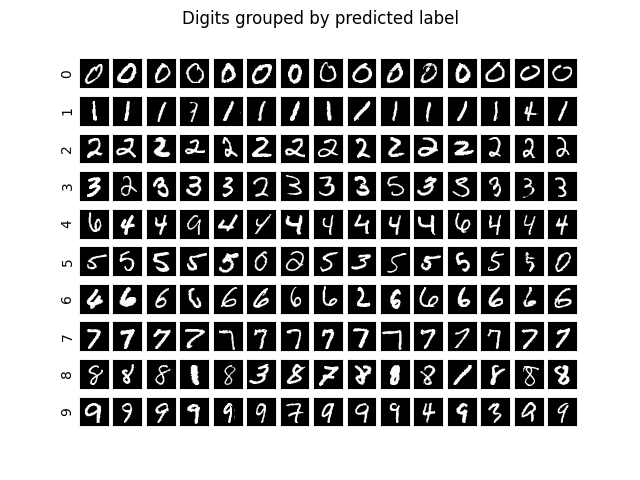

In [51]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

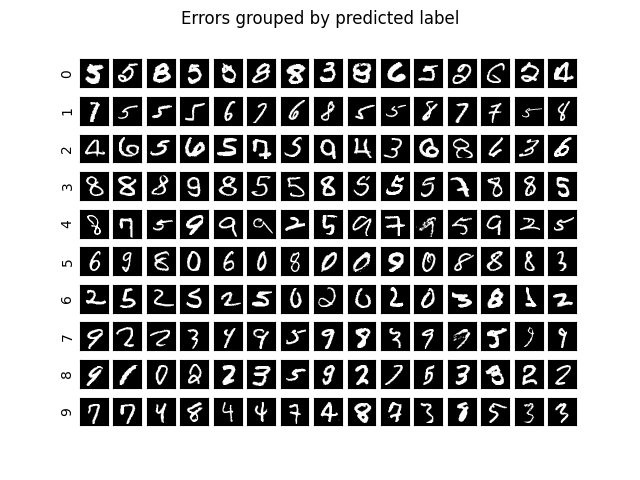

In [52]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

Text(0.5, 0.98, 'Errors grouped by predicted label')

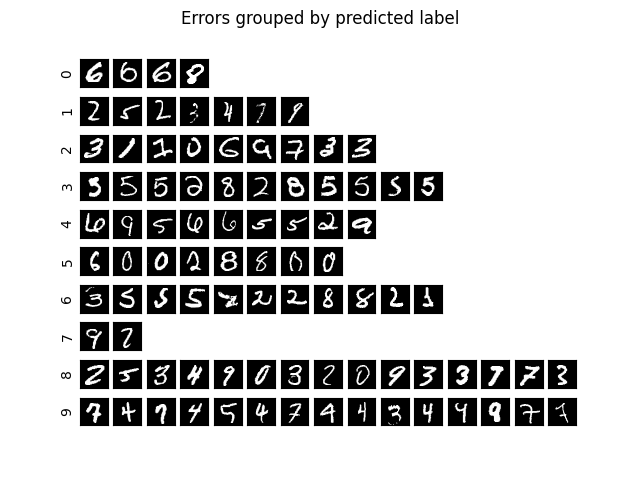

In [53]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [54]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

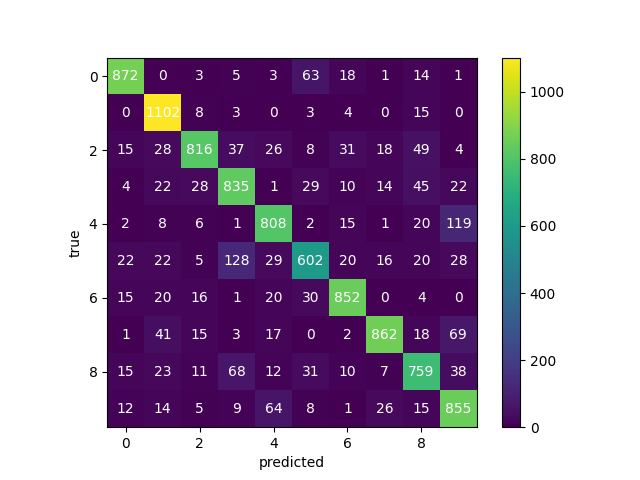

In [55]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937704
0.9859050917808865
0.8812574072791101


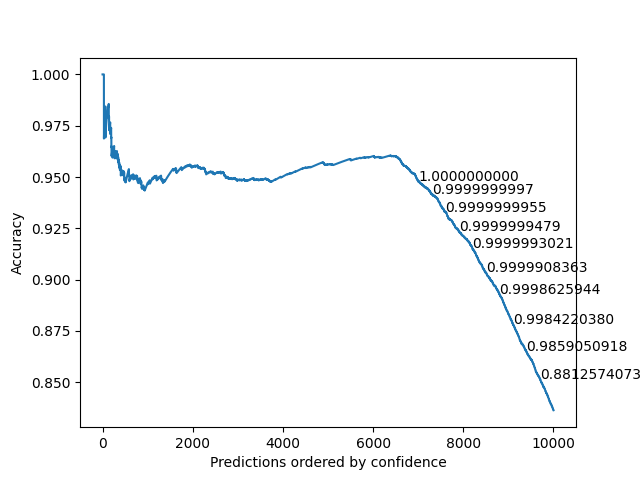

In [56]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

Text(0, 0.5, 'Accuracy')

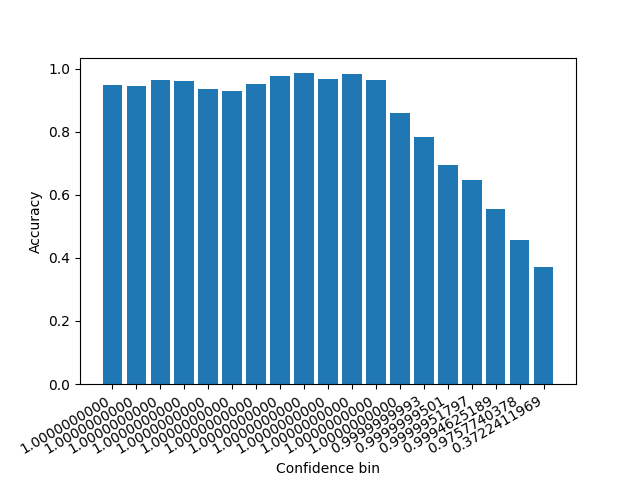

In [57]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 20) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [58]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True, random_state=42)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points


Finished for alpha = 0 with accuracy 0.0778
Finished for alpha = 1 with accuracy 0.3022
Finished for alpha = 2 with accuracy 0.8261333333333333
Finished for alpha = 3 with accuracy 0.8135833333333332
Finished for alpha = 4 with accuracy 0.8007500000000001
Finished for alpha = 5 with accuracy 0.7879833333333334
Finished for alpha = 6 with accuracy 0.7744333333333333
The best parameter choice is alpha = 2.00 with an accuracy score of 0.83.


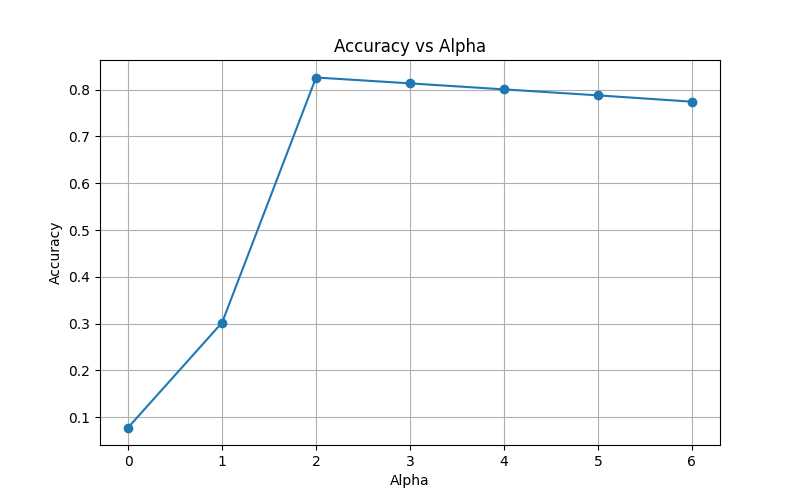

In [63]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from sklearn.model_selection import KFold
import sklearn.metrics
import matplotlib.pyplot as plt

# Initialize list of alpha values from 0 to 7
alphas = range(0, 7)
accuracy_scores = []

K = 5
Kf = KFold(n_splits=K, shuffle=True, random_state=42)
# Generate the splits once and reuse them for each alpha
splits = list(Kf.split(X))

for a in alphas:
    fold_accuracy = []
    # For each value of alpha, perform K-fold cross-validation
    for i_train, i_test in splits:
        X_train, y_train = X[i_train], y[i_train]
        X_test, y_test = X[i_test], y[i_test]

        model = nb_train(X_train, y_train, alpha=a)
        # Predict labels for the test fold
        pred = nb_predict(model, X_test)
        y_hat = pred["yhat"]
        # Calculate accuracy for the fold
        accuracy = sklearn.metrics.accuracy_score(y_test, y_hat)
        fold_accuracy.append(accuracy)
    # Store the mean accuracy over the folds for this alpha
    mean_accuracy = np.mean(fold_accuracy)
    accuracy_scores.append(mean_accuracy)
    print("Finished for alpha =", a, "with accuracy", mean_accuracy)

# Find the best alpha based on highest mean accuracy
best_alpha_idx = np.argmax(accuracy_scores)
best_alpha = alphas[best_alpha_idx]
best_accuracy = accuracy_scores[best_alpha_idx]

print("The best parameter choice is alpha = {:.2f} with an accuracy score of {:.2f}.".format(
    best_alpha, best_accuracy
))

# Plot accuracy vs alpha
plt.figure(figsize=(8, 5))
plt.plot(alphas, accuracy_scores, marker='o')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 5 Generating Data

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming nb_train and nb_predict functions are already implemented
# Ensure X and y are your training data and labels

def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]  # Shape: (C, D, K)
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D), dtype=int)
    for i in range(n):
        c = ygen[i]
        for d in range(D):
            # Extract log probabilities for feature d, class c
            log_probs = logcls[c, d, :]
            # Convert log probabilities to probabilities
            probs = np.exp(log_probs)
            # Normalize to ensure probabilities sum to 1
            probs /= np.sum(probs)
            # Sample from the categorical distribution
            Xgen[i, d] = np.random.choice(range(K), p=probs)
    return Xgen

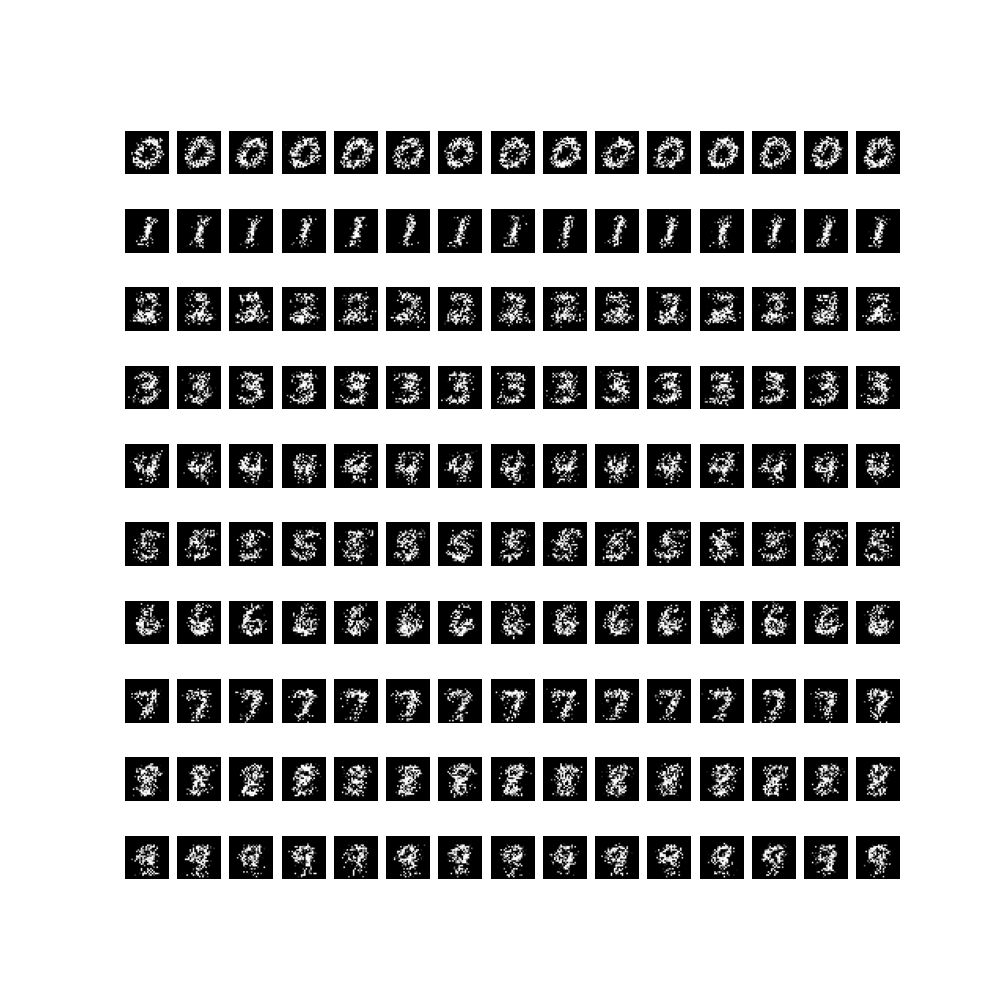

IndexError: index 10 is out of bounds for axis 0 with size 10

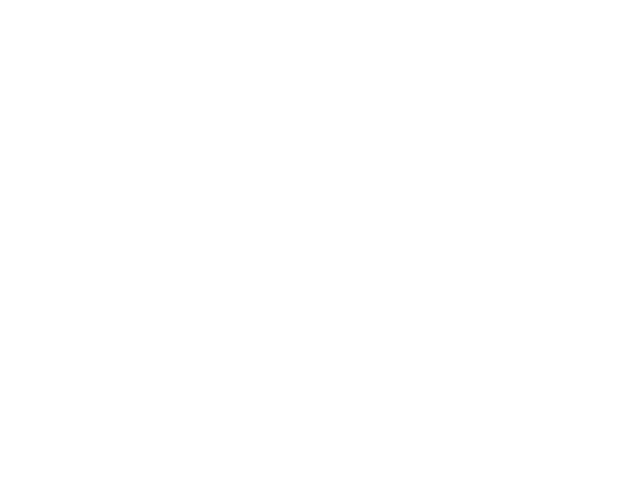

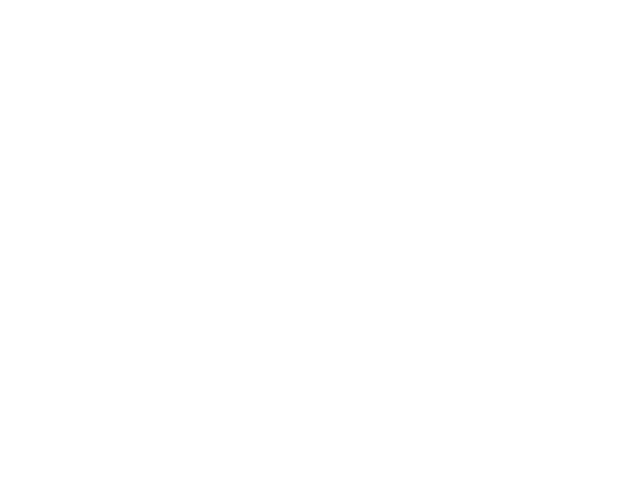

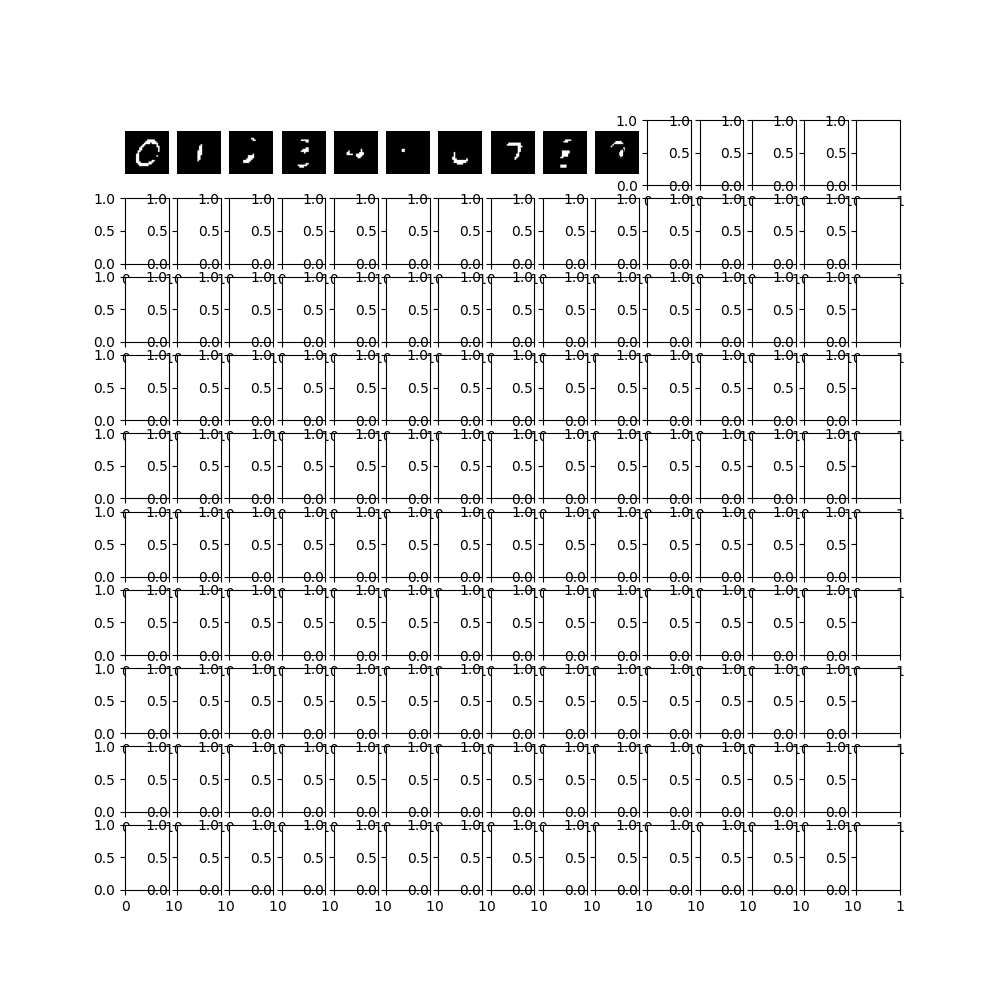

In [78]:
import numpy as np
import matplotlib.pyplot as plt

alphas = [1, 2, 10, 50]  # Different alpha values to test
num_digits_per_class = 15  # Number of digits to generate for each class
num_classes = 10  # For MNIST, we have 10 classes (0-9)

# Function to show digits in a grid
def showdigits(X, y):
    fig, axes = plt.subplots(10, 15, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')  # Adjust the shape as necessary for your data
        ax.axis('off')
    plt.show()

# Loop through the different alpha values and generate/plot digits for each
for alpha in alphas:
    # Train the Naive Bayes model with the current alpha
    model_nb = nb_train(X, y, alpha=alpha)
    
    # Cell 1: Generate digits for each class
    ygen = np.repeat(np.arange(num_classes), num_digits_per_class)
    Xgen = nb_generate(model_nb, ygen)

    plt.figure()
    showdigits(Xgen, ygen)
    plt.suptitle(f"Generated digits for each class (alpha={alpha})")
    
    # Cell 2: Most likely value of each feature per class
    ymax = np.arange(num_classes)
    Xmax = np.zeros((num_classes, X.shape[1]))
    for c in range(num_classes):
        Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb["logcls"][c, :, :])

    plt.figure()
    showdigits(Xmax, ymax)
    plt.suptitle(f"Most likely value of each feature per class (alpha={alpha})")

    # Cell 3: Expected value of each feature per class
    ymean = np.arange(num_classes)
    Xmean = np.zeros((num_classes, X.shape[1]))
    for c in range(num_classes):
        Xmean[c,] = np.apply_along_axis(
            np.sum, 1, np.exp(model_nb["logcls"][c, :, :]) * np.arange(256)
        )

    plt.figure()
    showdigits(Xmean, ymean)
    plt.suptitle(f"Expected value of each feature per class (alpha={alpha})")



# Image generation of the model with __alpha = 2__

Text(0.5, 0.98, 'Some generated digits for each class')

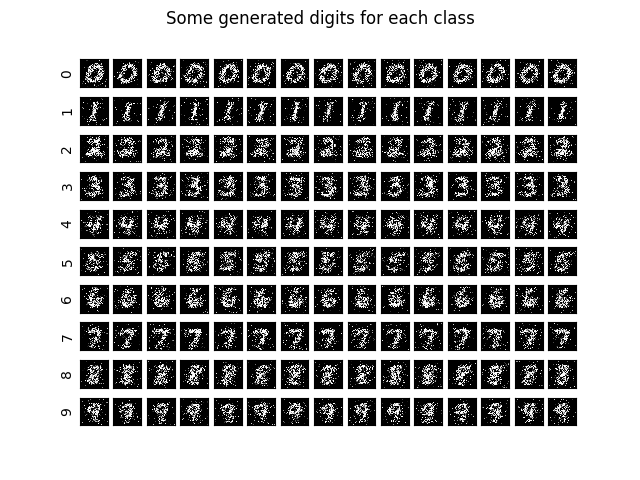

In [65]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

Text(0.5, 0.98, 'Most likely value of each feature per class')

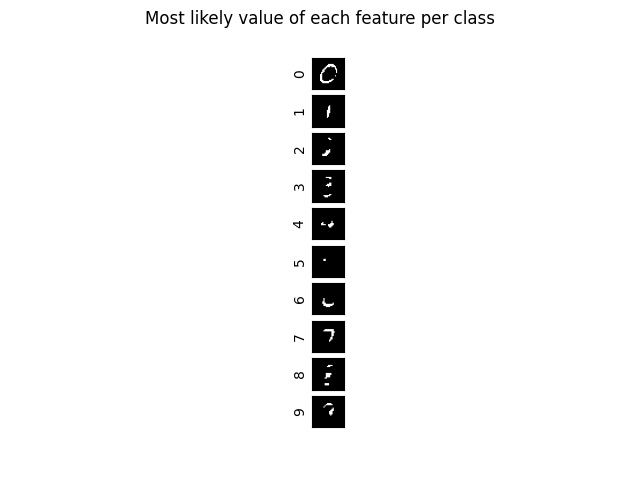

In [66]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

Text(0.5, 0.98, 'Expected value of each feature per class')

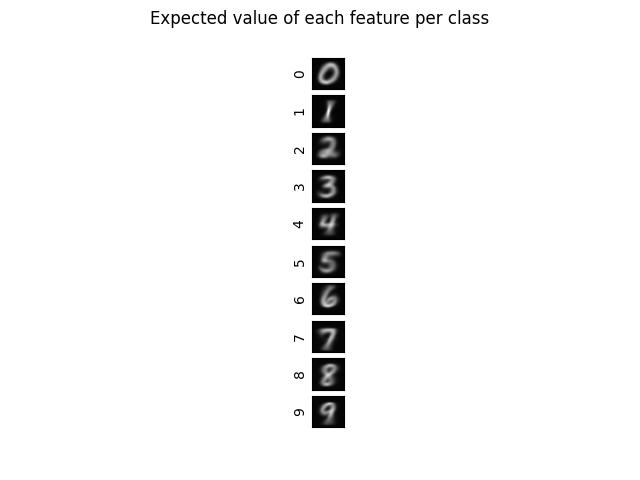

In [67]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")

# Image generation of the model with __alpha = 1__